<a href="https://colab.research.google.com/github/dmurphgarrett/covid/blob/master/test_ResNet_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os
import math
import copy
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from glob import glob
import random
import cv2
import shutil
# Helper libraries
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data_root = '/content/drive/My Drive/covid'
path_positive_cases = os.path.join('/content/drive/My Drive/covid/CT_COVID')
path_negative_cases = os.path.join('/content/drive/My Drive/covid/CT_NonCOVID')

In [5]:
# jpg and png files
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [6]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [7]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


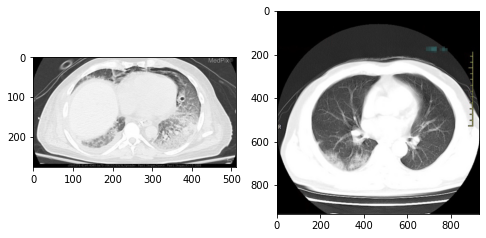

In [8]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#train-test split directory
subdirs = ['train/', 'test/']
for subdir in subdirs:
  labeldirs = ['CT_COVID', 'CT_NonCOVID']
  for labldir in labeldirs:
    newdir = subdir + labldir
    os.makedirs(newdir, exist_ok=True)

In [11]:
random.seed(123)
test_ratio = 0.1

for cases in [covid,non_covid]:
  total_cases = len(cases['images']) #total # of images
  num_to_select = int(test_ratio * total_cases) #imgs to copy to test set
  print(cases['class'], num_to_select)
  list_of_random_files = random.sample(cases['images'],num_to_select) #random file list
  
  for files in list_of_random_files:
    shutil.copy2(files, 'test/' + cases['class'])

CT_COVID 34
CT_NonCOVID 39


In [12]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [13]:
total_train_covid = len(os.listdir('/content/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/content/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/content/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/content/test/CT_NonCOVID'))

print("Train images Positive: {}".format(total_train_covid))
print("Train images Negative: {}".format(total_train_noncovid))
print("Val images Positive: {}".format(total_test_covid))
print("Val images Negative: {}".format(total_test_noncovid))

Train sets images COVID: 315
Train sets images Non COVID: 358
Test sets images COVID: 34
Test sets images Non COVID: 39


In [14]:
batch_size = 64
IMG_HEIGHT = 300
IMG_WIDTH = 300
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

train_files = glob('/content/train/CT_*/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3] for fn in train_files]
#print(train_labels)
validation_files = glob('/content/test/CT_*/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[3] for fn in validation_files]
print('Train dataset shape:', train_imgs.shape, 
 '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (673, 300, 300, 3) 	Validation dataset shape: (73, 300, 300, 3)


In [15]:
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [16]:
train_dir = os.path.join('/content/train')
test_dir = os.path.join('/content/test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [17]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 673 images belonging to 2 classes.


In [18]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 73 images belonging to 2 classes.


In [19]:
# import resnet 50 here!
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

model = ResNet50(include_top=False,weights='imagenet',input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


output = model.layers[-1].output
output = tf.keras.layers.Flatten()(output)
model = Model(model.input, output)
for layer in model.layers:
    layer.trainable = False
#model.summary()

94773248/94765736 [==============================] - 1s 0us/step


In [41]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

# from tensorflow_addons.metrics import F1Score
# optimizers.Adam(lr=0.001)
main_model = Sequential()
main_model.add(model)
main_model.add(Dense(512, activation='relu', input_dim=(IMG_HEIGHT,IMG_WIDTH,3)))
main_model.add(Dropout(0.3))
main_model.add(Dense(512, activation='relu'))
main_model.add(Dropout(0.3))
main_model.add(Dense(1, activation='sigmoid'))
main_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
main_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 204800)            23587712  
_________________________________________________________________
dense_27 (Dense)             (None, 512)               104858112 
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 128,708,993
Trainable params: 105,121,281
Non-trainable params: 23,587,712
______________________________

In [ ]:
# history = main_model.fit_generator(train_data_gen, 
#                               steps_per_epoch=5, 
#                               epochs=15,
#                               validation_data=test_data_gen, 
#                               validation_steps=1, 
#                               verbose=1)
history = main_model.fit(train_data_gen,batch_size=32,epochs=100,validation_data=test_data_gen)


Epoch 1/100
11/11 [==============================] - 11s 1s/step - loss: 1.3006 - accuracy: 0.5141 - val_loss: 0.6778 - val_accuracy: 0.5068
Epoch 2/100
11/11 [==============================] - 10s 939ms/step - loss: 0.9005 - accuracy: 0.5171 - val_loss: 0.8674 - val_accuracy: 0.4658
Epoch 3/100
11/11 [==============================] - 10s 937ms/step - loss: 0.7395 - accuracy: 0.5617 - val_loss: 0.6508 - val_accuracy: 0.6164
Epoch 4/100
11/11 [==============================] - 11s 955ms/step - loss: 0.7389 - accuracy: 0.5572 - val_loss: 0.6802 - val_accuracy: 0.5616
Epoch 5/100
11/11 [==============================] - 10s 935ms/step - loss: 0.6835 - accuracy: 0.5929 - val_loss: 0.6862 - val_accuracy: 0.5479
Epoch 6/100
11/11 [==============================] - 10s 929ms/step - loss: 0.6621 - accuracy: 0.6122 - val_loss: 0.6440 - val_accuracy: 0.6164
Epoch 7/100
11/11 [==============================] - 10s 919ms/step - loss: 0.6799 - accuracy: 0.5929 - val_loss: 0.6832 - val_accuracy: 0.

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
main_model.save('covid_cnn_version_on.h5')
